# Multi-agent Simulation

This tutorial demonstrates how to run a simple closed-loop simulation with multiple pre-defined sim agents.

In [1]:
%config Completer.use_jedi = False

import jax
from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization

2024-06-13 13:37:53.851376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Config dataset:
max_num_objects = 32

config = dataclasses.replace(_config.WOD_1_0_0_VALIDATION, max_num_objects=max_num_objects)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)

In [3]:
scenario.log_trajectory.x.devices()

{cuda(id=0)}

In [4]:
print(scenario.object_metadata.ids)
print(scenario.object_metadata.is_valid)

print(scenario.log_trajectory.shape)
scenario.log_trajectory.shape[:-1]

[2667 2668 3939 2666 2665 2663 2664 2670 2673 2671 2672 2675 2678 2674
 2676 2679 2680 2681   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False False False False False]
(32, 91)


(32,)

## Initializing and Running the Simulator

Waymax uses a Gym-like interface for running closed-loop simulation. 

The `env.MultiAgentEnvironment` class defines a stateless simulation interface with the two key methods:
- The `reset` method initializes and returns the first simulation state.
- The `step` method transitions the simulation and takes as arguments a state and an action and outputs the next state.

Crucially, the `MultiAgentEnvironment` does not hold any simulation state itself, and the `reset` and `step` functions have no side effects. This allows us to use functional transforms from JAX, such as using jit compilation to optimize the compuation. It also allows the user to arbitrarily branch and restart simulation from any state, or save the simulation by simply serializing and saving the state object.



In [5]:
# Config the multi-agent environment:
init_steps = 11

# Set the dynamics model the environment is using.
# Note each actor interacting with the environment needs to provide action
# compatible with this dynamics model.
dynamics_model = dynamics.StateDynamics()

# Expect users to control all valid object in the scene.
env = _env.MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects=max_num_objects,
        controlled_object=_config.ObjectType.VALID,
    ),
)

We now create a set of sim agents to run in simulation. By default, the behavior of an object that is not controlled is to replay the behavior stored in the dataset (log playback).

For each sim agent, we define the algorithm (such as IDM), and specify which objects the agent controls via the `is_controlled_func`, which is required to return a boolean mask marking which objects are being controlled.

The IDM agent we use in this example is the `IDMRoutePolicy`, which follows the spatial trajectory stored in the logs, but adjusts the speed profile based on the IDM rule, which will stop or speed up according to the distance between the vehicle and any objects in front of the vehicle. For the remaining agents, we set them to use a constant speed policy which will follow the logged route with a fixed, constant speed.

In [6]:
# Setup a few actors, see visualization below for how each actor behaves.

# An actor that doesn't move, controlling all objects with index > 4
obj_idx = jnp.arange(max_num_objects)
static_actor = agents.create_constant_speed_actor(
    speed=0.0,
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: obj_idx > 4,
)

# IDM actor/policy controlling both object 0 and 1.
# Note IDM policy is an actor hard-coded to use dynamics.StateDynamics().
actor_0 = agents.IDMRoutePolicy(
    is_controlled_func=lambda state: (obj_idx == 0) | (obj_idx == 1)
)

# Constant speed actor with predefined fixed speed controlling object 2.
actor_1 = agents.create_constant_speed_actor(
    speed=10.0,
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: obj_idx == 2,
)

# Exper/log actor controlling objects 3 and 4.
actor_2 = agents.create_expert_actor(
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: (obj_idx == 3) | (obj_idx == 4),
)

actors = [static_actor, actor_0, actor_1, actor_2]

We can (optionally) jit the step and select action functions to speed up computation.

In [7]:
jit_step = jax.jit(env.step)
jit_select_action_list = [jax.jit(actor.select_action) for actor in actors]

In [8]:
action_0 = actor_0.select_action({}, scenario, None, None)
action_0.action.data[1]

Array([ 1.4825952e+03, -1.3278727e+04,  1.5727265e+00,  9.9756174e-02,
        2.2734070e+01], dtype=float32)

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


""

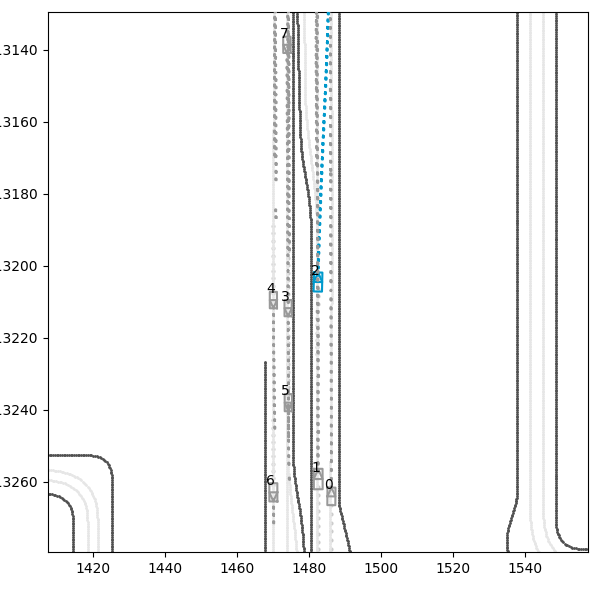

In [9]:
# plot the initial state
import mediapy
state = [env.reset(scenario)][0]

# check how many traj/agents are in the scenario
print(state.current_sim_trajectory.valid)

img = visualization.plot_simulator_state(state)
mediapy.show_image(img)

In [10]:
from waymax.datatypes.simulator_state import update_state_by_log
state.remaining_timesteps

state_next = update_state_by_log(state, 1)
state_next.remaining_timesteps

Array(79, dtype=int32)

We can now write a for loop to all of these agents in simulation together.


In [11]:
states = [env.reset(scenario)]
for _ in range(states[0].remaining_timesteps):
  current_state = states[-1]
  # print('timestep of the current state: ', current_state.timestep)
  # print('current traj: ', current_state.sim_trajectory.timestamp_micros)
  outputs = [
      jit_select_action({}, current_state, None, None)
      for jit_select_action in jit_select_action_list
  ]
  action = agents.merge_actions(outputs)
  next_state = jit_step(current_state, action)

  states.append(next_state)

## Visualization of simulation.

We can now visualize the result of the simulation loop.

On the left side:
- Objects 5, 6, and 7 (controlled by static_actor) remain static.
- Objects 3 and 4 controlled by log playback, and collide with objects 5 and 6.

On the right side:
- Object 2 controlled by actor_1 is moving at constant speed 5m/s (i.e. slower than log in this case).
- Object 0 and 1, controlled by the IDM agent, follow the log in the beginning, but object 1 slows down when approaching object 2.

In [12]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False))
mediapy.show_video(imgs, fps=10)